In [1]:
import yfinance as yf

ticker = "AAPL"
data_original = yf.download(ticker, start="2015-01-01", end="2025-01-01", auto_adjust=False)

print(data_original.columns)
print(data_original.head())


[*********************100%***********************]  1 of 1 completed

MultiIndex([('Adj Close', 'AAPL'),
            (    'Close', 'AAPL'),
            (     'High', 'AAPL'),
            (      'Low', 'AAPL'),
            (     'Open', 'AAPL'),
            (   'Volume', 'AAPL')],
           names=['Price', 'Ticker'])
Price       Adj Close      Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                                        
2015-01-02  24.261047  27.332500  27.860001  26.837500  27.847500  212818400
2015-01-05  23.577572  26.562500  27.162500  26.352501  27.072500  257142000
2015-01-06  23.579794  26.565001  26.857500  26.157499  26.635000  263188400
2015-01-07  23.910442  26.937500  27.049999  26.674999  26.799999  160423600
2015-01-08  24.829126  27.972500  28.037500  27.174999  27.307501  237458000


In [2]:
# Extract 'Adj Close' from MultiIndex 
# Keep it as a DataFrame
adj_close_df = data_original.loc[:, [('Adj Close', 'AAPL')]]  # still MultiIndex
adj_close_df.columns = ['Adj Close']  # flatten column name

print(adj_close_df.head())


            Adj Close
Date                 
2015-01-02  24.261047
2015-01-05  23.577572
2015-01-06  23.579794
2015-01-07  23.910442
2015-01-08  24.829126


In [3]:
# Use adjusted close for returns
prices = adj_close_df["Adj Close"]

# Compute log returns
import numpy as np
returns = np.log(prices / prices.shift(1)).dropna() # Shifts backward (t-1) so the first entry is NaN
adj_close_df['Returns']=returns

print(adj_close_df.head())
#print(returns.head())

            Adj Close   Returns
Date                           
2015-01-02  24.261047       NaN
2015-01-05  23.577572 -0.028576
2015-01-06  23.579794  0.000094
2015-01-07  23.910442  0.013925
2015-01-08  24.829126  0.037702


In [7]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# -------------------------
# Black-Scholes call price
# -------------------------
def bs_call_price(S, K, T, r, sigma):
    """European Call option price using Black-Scholes"""
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

# -------------------------
# Parameters
# -------------------------
S_prices = prices  # underlying Adj Close Series
window = 250       # historical scenario window
alpha = 0.99       # confidence level
r = 0.03           # risk-free rate
sigma = 0.25       # implied vol
T0 = 30/252        # 30 days to expiry

# Option strike (for example, 5% above spot at each scenario start)
strike_pct = 1.05

# Take last 500 days: 250 for scenario + 250 for backtest
prices_bt = S_prices[-(window+250):]

# -------------------------
# Rolling 250-day backtest
# -------------------------
results = []

for i in range(250):
    # Historical scenario window
    scenario_prices = prices_bt[i:i+window]
    returns = np.log(scenario_prices / scenario_prices.shift(1)).dropna()
    
    # Option parameters
    S0 = scenario_prices.iloc[-1]
    K = S0 * strike_pct
    T = T0  # can decay daily if desired
    
    # Generate scenarios
    scenario_underlyings = S0 * np.exp(returns)
    
    # Compute P&L of option under each scenario
    pnl_scenarios = np.array([bs_call_price(S, K, T, r, sigma) - bs_call_price(S0, K, T, r, sigma)
                              for S in scenario_underlyings])
    
    # Historical VaR and ES
    VaR = np.quantile(pnl_scenarios, 1-alpha)
    ES  = pnl_scenarios[pnl_scenarios <= VaR].mean()
    
    # Actual next-day P&L
    actual_price = prices_bt.iloc[i+window]
    actual_pnl = bs_call_price(actual_price, K, T, r, sigma) - bs_call_price(S0, K, T, r, sigma)
    
    # Record
    results.append({
        'Date': prices_bt.index[i+window],
        'VaR': VaR,
        'Expected_Shortfall': ES,
        'Actual_PnL': actual_pnl,
        'VaR_Breached': actual_pnl <= VaR
    })

# Convert to DataFrame
backtest_df = pd.DataFrame(results)

# Count number of breaches
num_breaches = backtest_df['VaR_Breached'].sum()

print(backtest_df)
print(f"\nNumber of VaR breaches in last 250 days: {num_breaches}")


          Date       VaR  Expected_Shortfall  Actual_PnL  VaR_Breached
0   2024-01-04 -1.499784           -1.733416   -0.671995         False
1   2024-01-05 -1.480737           -1.711402   -0.222247         False
2   2024-01-08 -1.474794           -1.704534    1.592047         False
3   2024-01-09 -1.510447           -1.745741   -0.129348         False
4   2024-01-10 -1.507029           -1.741790    0.340465         False
..         ...       ...                 ...         ...           ...
245 2024-12-24 -2.085367           -2.490363    0.990498         False
246 2024-12-26 -2.109303           -2.518948    0.262923         False
247 2024-12-27 -2.116002           -2.526947   -0.986206         False
248 2024-12-30 -1.907574           -2.384082   -0.974561         False
249 2024-12-31 -1.882273           -2.352461   -0.533617         False

[250 rows x 5 columns]

Number of VaR breaches in last 250 days: 2


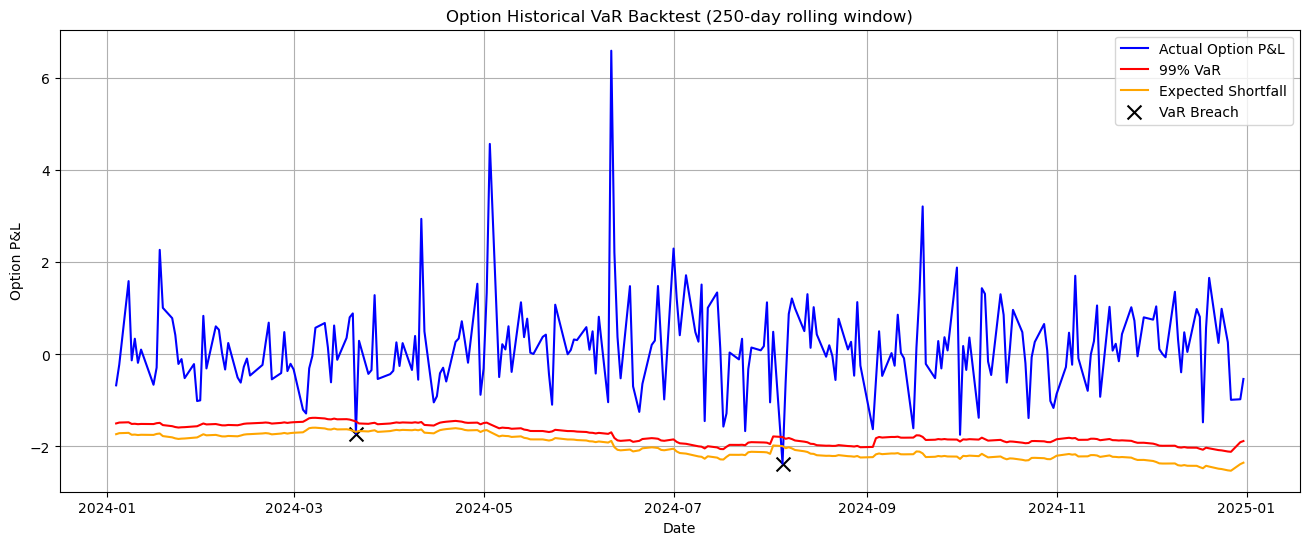

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))

# Plot actual option P&L
plt.plot(backtest_df['Date'], backtest_df['Actual_PnL'], label='Actual Option P&L', color='blue')

# Plot 99% VaR
plt.plot(backtest_df['Date'], backtest_df['VaR'], label='99% VaR', color='red')

# Plot Expected Shortfall
plt.plot(backtest_df['Date'], backtest_df['Expected_Shortfall'], label='Expected Shortfall', color='orange')

# Highlight breaches
breaches = backtest_df[backtest_df['VaR_Breached']]
plt.scatter(breaches['Date'], breaches['Actual_PnL'], color='black', marker='x', s=100, label='VaR Breach')

plt.title('Option Historical VaR Backtest (250-day rolling window)')
plt.xlabel('Date')
plt.ylabel('Option P&L')
plt.legend()
plt.grid(True)
plt.show()
